## 5 encontro

- Plotar o grafico da melhor fitness (melhor e media) por geração

- Grafico de convergencia com os dados associados

- gerações = 100 , pop = 20, 90% crossover e 5% mutação 

- Funcoes Objetivos: Rastrigin, optmization

- Elitisimo simples (melhor individuo da geração preservado)

- Funcao que faz RCE e chamar a cada 20% do numero de gerações total

- Implementar repopulação 

- Nao apagar os clones 

- Apresentar a melhor solução no final - Valores das variaveis de decisão e valor da aptidão

- Tempo de execução

- Armazenar varias execuções do algoritimo em sequencia e extrair media e desvio padrão da melhor solução e dos tempos de execução

## Solid

In [237]:
import numpy as np
import math
from deap import base, creator, tools
import random
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
import json
import pandas as pd

In [238]:

class Setup:
    def __init__(self):
        self.CXPB, self.MUTPB, self.NGEN, self.POP_SIZE = 0.9, 0.05, 100, 100
        self.IND_SIZE = 10
        self.evaluations = 0

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)
        
        self.toolbox = base.Toolbox()
        self.toolbox.register("attribute", random.random)
        self.toolbox.register("individual", tools.initRepeat, creator.Individual, self.toolbox.attribute, n=self.IND_SIZE)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        
        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
        self.toolbox.register("select", tools.selTournament, tournsize=3)
        self.toolbox.register("evaluate", self.evaluate)

    def evaluate(self, individual):
        self.evaluations += 1
        rastrigin = 10 * self.IND_SIZE
        for i in range(self.IND_SIZE):
            rastrigin += (individual[i]*individual[i] - 10 * (math.cos(2*np.pi*individual[i])))
        return rastrigin

    def rosenbrock(self,x):
        return np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)


    def globalSolutions(self):
        # Definição das dimensões do espaço de busca
        n_dimensions = 2

        try:
            # Busca pelo ótimo global da função Rastrigin
            rastrigin_result = minimize(self.evaluate, x0=np.zeros(n_dimensions), method='BFGS')
            rastrigin_minimum = rastrigin_result.fun
            rastrigin_solution = rastrigin_result.x

            # Busca pelo ótimo global da função Rosenbrock
            rosenbrock_result = minimize(self.rosenbrock, x0=np.zeros(n_dimensions), method='BFGS')
            rosenbrock_minimum = rosenbrock_result.fun
            rosenbrock_solution = rosenbrock_result.x

        except Exception as e:
            print("Erro ao tentar encontrar o ótimo global das funções: ", e)
            

        # Impressão dos resultados
        print("\n\nÓtimo global da função Rastrigin: ", rastrigin_minimum)
        print("Solução: ", rastrigin_solution)
        print()
        print("Ótimo global da função Rosenbrock: ", rosenbrock_minimum)
        print("Solução: ", rosenbrock_solution)




In [239]:

class DataExploration:

    def __init__(self):
        self.fit_array = []

        # Função para calcular a média dos valores de fitness de cada geração
    def calculate_stats(self,logbook):

        fit_avg = logbook.select("avg")
        fit_std = logbook.select("std")
        fit_min = logbook.select("min")
        fit_max = logbook.select("max")
        self.fit_array.append(fit_min)
        self.fit_array.append(fit_avg)
        self.fit_array.append(fit_max)
        self.fit_array.append(fit_std)


        return {
            "min_fitness": fit_min,
            "max_fitness": fit_max,
            "avg_fitness":fit_avg,
            "std_fitness": fit_std
        }


    def visualize(self,logbook,pop):      
        generation = logbook.select("gen")
        statics = self.calculate_stats(logbook)
        best_solution_index = statics["min_fitness"].index(min( statics["min_fitness"]))
        best_solution_variables = pop[best_solution_index]
        best_solution_fitness =  statics["min_fitness"][best_solution_index]

        print("Best solution variables \n", best_solution_variables)
        print("Best solution fitness \n", best_solution_fitness)

        self.grafico_convergencia(generation,statics)
        self.plot_diversity(generation,logbook)
        


    def grafico_convergencia(self,gen,lista):
        """ A convergência refere-se à tendência do algoritmo em direção a uma solução ótima. Pode ser avaliada visualmente observando o comportamento da média, mediana ou melhor fitness ao longo das gerações. Se esses valores estiverem estabilizando ou melhorando, indica que o algoritmo está convergindo."""
        fig, ax1 = plt.subplots()
        line1 = ax1.plot(gen, lista["min_fitness"], "*b-", label="Minimum Fitness")
        line2 = ax1.plot(gen, lista["avg_fitness"], "+r-", label="Average Fitness")
        line3 = ax1.plot(gen, lista["max_fitness"], "og-", label="Maximum Fitness")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Fitness")
        lns = line1 + line2 + line3
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc="upper right")
        plt.show()


    def graficoBarrasFitnessGeneration(self,best_solutions_array, num_gen,fitness_mean):
        fig, ax = plt.subplots()
        generations = np.arange(2, num_gen + 1)
        print(len(generations))
        best_solutions = [best[0] for best in best_solutions_array if best]
        print(len(best_solutions))

    
        
        # Plotagem dos valores de melhor fitness por geração
        ax.bar(generations, best_solutions, color='b', label='Melhor Fitness')
        
        # Linha da média
        ax.axhline(y=fitness_mean, color='r', linestyle='--', label='Média Fitness')
        
        ax.set_xlabel('Geração')
        ax.set_ylabel('Fitness')
        ax.set_title('Melhor Fitness por Geração')
        ax.legend()
        plt.show()

    def plot_diversity(self,gen,logbook):
        diversity = logbook.select("diversity")
        print(f"Diversidade :  {diversity}")

        plt.plot(gen, diversity, "-b")
        plt.xlabel("Generation")
        plt.ylabel("Diversity")
        plt.title("Population Diversity")
        plt.show()



In [240]:


class AlgEvolution:
    def __init__(self, setup):
        self.setup = setup
        self.stats = tools.Statistics(key=lambda ind: ind.fitness.values)
        self.stats.register("avg", np.mean)
        self.stats.register("std", np.std)
        self.stats.register("min", np.min)
        self.stats.register("max", np.max)
        self.logbook = tools.Logbook()
        self.hof = tools.HallOfFame(1)
        self.pop = self.setup.toolbox.population(n=self.setup.POP_SIZE)
        self.hof.update(self.pop)

        self.best_solutions_array = []
        self.best_individual_array =[]



    def apply_elitism(self, population):
        # Sort the population based on fitness
        population.sort(key=lambda x: x.fitness.values)

        # Replace the worst individuals with the best individuals from the Hall of Fame
        for i in range(len(self.hof)):
            population[-(i+1)] = self.setup.toolbox.clone(self.hof[i])
            
    def calculaTempo(self,x1,x2):
        return x1 - x2

    def run(self):
        data = {}
        #! Evaluate the entire population
        fitnesses = map(self.setup.toolbox.evaluate, self.pop)
        for ind, fit in zip(self.pop, fitnesses):
            ind.fitness.values = [fit]

        for g in range(self.setup.NGEN):

            # Select the next generation individuals
            offspring = self.setup.toolbox.select(self.pop, k=len(self.pop))

            # Clone the selected individuals
            offspring = [self.setup.toolbox.clone(ind) for ind in offspring]

            #! Apply crossover and mutation on the offspring
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < self.setup.CXPB:
                    self.setup.toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            for mutant in offspring:
                if random.random() < self.setup.MUTPB:
                    self.setup.toolbox.mutate(mutant)
                    del mutant.fitness.values

            # Evaluate the individuals with an invalid fitness
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(self.setup.toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = [fit]

            # The population is entirely replaced by the offspring
            self.pop[:] = offspring



            #! Dados da geração
            #print(f"Geração {g+1} - Melhor individuo = {self.hof[0]} - Fit = {self.hof[0].fitness}",)
            print(f"Geração {g+1} - Melhor individuo = {round(self.hof[0][0],2)} - Fit = {self.hof[0].fitness}",)
            self.best_solutions_array.append(self.hof[0].fitness.values)
            print(f"Evaluations = {self.setup.evaluations}\n")
            data["Generations"] = g+1
            data["Best Solution"] = round(self.hof[0][0],2)
            data["Evaluations"] = self.setup.evaluations
            #data["Media da Geração"]= self.stats["avg"]
            self.best_individual_array.append(data)

            #! Elitism            
            # Update best with new pop
            self.hof.update(self.pop) 

            # Update pop with best
            self.pop[0] = self.setup.toolbox.clone(self.hof[0])

            # Apply elitism
            self.apply_elitism(self.pop)



            #! Save each generation record in the logbook
            record = self.stats.compile(self.pop)
            self.logbook.record(gen=g, **record)

        best_df = pd.read_json(json.dumps(self.best_individual_array),orient='records')
        display(best_df)

        return self.pop, self.logbook, self.hof[0]


/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Geração 1 - Melhor individuo = 0.53 - Fit = ()
Evaluations = 188

Geração 2 - Melhor individuo = 0.07 - Fit = (37.32215338248528,)
Evaluations = 279

Geração 3 - Melhor individuo = 0.07 - Fit = (37.32215338248528,)
Evaluations = 373

Geração 4 - Melhor individuo = 0.07 - Fit = (29.742478058683954,)
Evaluations = 461

Geração 5 - Melhor individuo = 0.12 - Fit = (23.603388103175504,)
Evaluations = 546

Geração 6 - Melhor individuo = 0.12 - Fit = (23.19235991194718,)
Evaluations = 638

Geração 7 - Melhor individuo = 0.12 - Fit = (19.33243488186156,)
Evaluations = 725

Geração 8 - Melhor individuo = 0.12 - Fit = (12.964696555379868,)
Evaluations = 821

Geração 9 - Melhor individuo = 0.12 - Fit = (11.693258749954362,)
Evaluations = 917

Geração 10 - Melhor individuo = 0.02 - Fit = (9.026135909041212,)
Evaluations = 1008

Geração 11 - Melhor individuo = 0.02 - Fit = (7.754698103615706,)
Evaluations = 1101

Geração 12 - Melhor individuo = 0.02 - Fit = (7.058970965617089,)
Evaluations = 1188



/tmp/ipykernel_91071/1624571083.py:95: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  best_df = pd.read_json(json.dumps(self.best_individual_array),orient='records')


,Generations,Best Solution,Evaluations
0,100,0.02,9232
1,100,0.02,9232
2,100,0.02,9232
3,100,0.02,9232
4,100,0.02,9232
...,...,...,...
95,100,0.02,9232
96,100,0.02,9232
97,100,0.02,9232
98,100,0.02,9232




Média dos valores de fitness por geração: 2.110187194320354
99
Best solution variables 
 [0.02287331189696662, -0.003971738003848729, 0.03606554230144632, 0.03586466804573574, 0.04904820091991945, 0.03584156400967686, 0.032119674636575946, -0.0069931753059242485, 0.007457243043523132, 0.033714544046089825]
Best solution fitness 
 1.7945229812319958


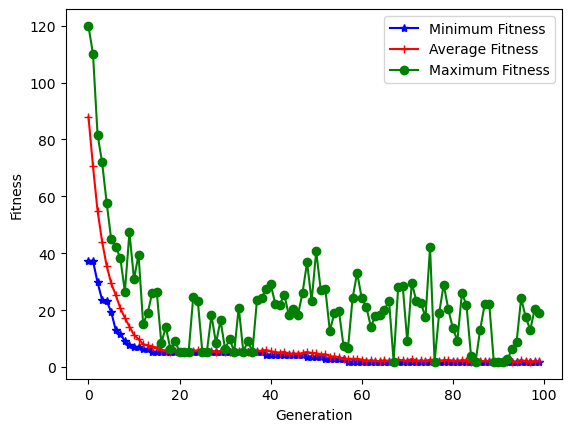

Diversidade :  [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


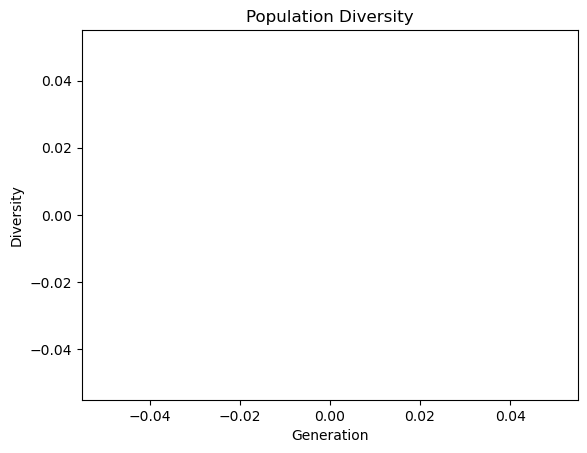

99
99


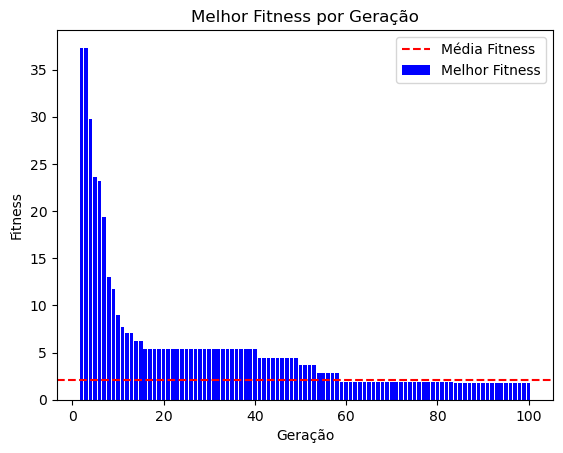

Tempo total de execução: 1.14 segundos


In [241]:


def main():     
    tempo1 = time.time()


    #!setup
    data_visual = DataExploration()
    setup = Setup()
    alg = AlgEvolution(setup)

    #!loop
    #setup.globalSolutions()
    pop, logbook, best = alg.run()
    stats_data = data_visual.calculate_stats(logbook)
    media = stats_data["avg_fitness"]

    #!Results           
    #print("Best solution variables \n", best)
    #print("Best solution fitness \n", best.fitness)
    print("\n\nMédia dos valores de fitness por geração:",media.pop() )
    data_visual.visualize(logbook,pop)
    data_visual.graficoBarrasFitnessGeneration(alg.best_solutions_array,setup.NGEN,media.pop())

    tempo2 = time.time()    
    print(f"Tempo total de execução: {round(tempo2-tempo1,2)} segundos",)    


if __name__ == "__main__":
    main()